# yaspy tutorial

Here we show how you can use yaspy to generate surface screenshots and multi-panel surface plots fast.

To run the tutorial, you will need a few extra dependencies. If you don't have them already, you can install them with pip.

```bash
pip install neuromaps nilearn
```

In [1]:
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from neuromaps.datasets import fetch_annotation, fetch_fslr
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import yaspy

In [2]:
# Nb, If running on a remote linux server, you may need this.

# import pyvista as pv
# pv.start_xvfb()

In [3]:
plt.style.use("bmh")
plt.rcParams["figure.dpi"] = 150

## Downloading data

First, we fetch the surfaces and overlay data needed for the demo. We're using the 32k_fs_LR surface template and the RSFC principal gradient map.

In [4]:
# 32k_fs_LR surfaces and sulcal depth map
surfaces = fetch_fslr()
surf_lh_path, surf_rh_path = surfaces["inflated"]
sulc_lh_path, sulc_rh_path = surfaces["sulc"]
print(surf_lh_path)
print(sulc_lh_path)

/Users/clane/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_inflated.surf.gii
/Users/clane/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_desc-sulc_midthickness.shape.gii


## Basic screenshots

Let's see how you can take a basic screenshot with yaspy. First we create a `Plotter` object for the given surface. We also specify the hemisphere, which helps with setting up the correct views.

This first screenshot just shows the left lateral view of the cortex.

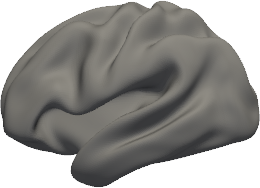

In [5]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh")
plotter_lh.screenshot()

The `screenshot()` method just returns a static image in the form of a [PIL](https://pillow.readthedocs.io/en/stable/index.html) `Image` instance. In a notebook, a PIL `Image` just displays as an embedded png, so you get a quick visualization for free.

Under the hood, yaspy uses [PyVista](https://pyvista.org/), which in turn builds on [VTK](https://vtk.org/) to render surface plots fast. 

To save a screenshot, you can just use the `Image.save()` method of the returned PIL Image.

In [6]:
img = plotter_lh.screenshot()
img.save("example.png")

Now let's take another screenshot with a different view. We can reuse the same plotter and just change the view.

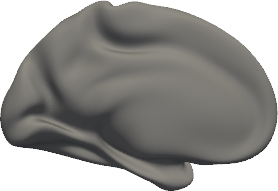

In [7]:
plotter_lh.screenshot("medial")

All of the available views are enumerated in `yaspy.View`.

In [8]:
print("Available views:\n")

for view in yaspy.View:
    print(view.value)

Available views:

lateral
medial
posterior
anterior
inferior
superior


You can also provide a custom camera position as a view. A camera position is a tuple of three tuples:

- position: the (x, y, z) position of the camera in world coordinates.
- focal_point: the (x, y, z) position where the camera is pointing.
- viewup: the upward direction vector for the camera.

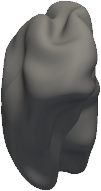

In [9]:
plotter_lh.screenshot(
    (
        (0, -500, -200),  # camera view from back and slightly below
        (0, 0, 0),  # looking at coordinate center,
        (0, 0, 1),  # camera oriented so that up is aligned with z axis.
    )
)

By default, the screenshots are cropped tight to the surface and have a transparent background. You can also add padding and a background color.

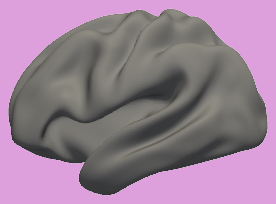

In [10]:
# Basic screenshot with padding and background
plotter_lh.screenshot(pad=8, color="plum")

## Custom surfaces

If you want to view a custom surface, for example a subject specific surface, you can pass a path to a different surface gifti file. Here we'll just try out the 32K_fs_LR midthickness surface.

Custom surface: /Users/clane/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii


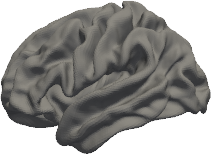

In [11]:
custom_surf_path = surfaces["midthickness"][0]
print("Custom surface:", custom_surf_path)

plotter_lh = yaspy.Plotter(custom_surf_path, hemi="lh")
plotter_lh.screenshot()

If the file format of your surface is not supported, you can also load the surface yourself and pass a tuple of `(points, faces)`.

In [12]:
surf = nib.load(custom_surf_path)
points, faces = surf.darrays[0].data, surf.darrays[1].data
print("Points:", points.shape, points.dtype)
print("Faces:", faces.shape, faces.dtype)

Points: (32492, 3) float32
Faces: (64980, 3) int32


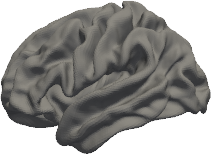

In [13]:
plotter_lh = yaspy.Plotter((points, faces), hemi="lh")
plotter_lh.screenshot()

## Overlays

Now let's add some overlays. We can start by adding a binary sulcal depth map by passing a path to the `sulc` shape file.

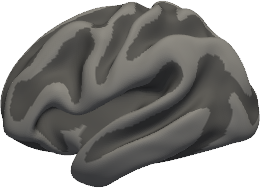

In [14]:
# Basic screenshot with sulc outline
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)
plotter_lh.screenshot()

Next let's add on top a functional activation overlay using the `Plotter.overlay()` method.

To start, we'll download the RSFC principal gradient map from (Margulies et al., 2016) to use for testing.

In [15]:
# Load margulies gradient for some overlay testing
grad_lh_path, grad_rh_path = fetch_annotation(
    source="margulies2016", desc="fcgradient01", space="fsLR", den="32k"
)

grad_lh = nib.load(grad_lh_path).darrays[0].data
grad_rh = nib.load(grad_rh_path).darrays[0].data
print(grad_lh.shape, grad_rh.shape)

(32492,) (32492,)


The `overlay()` method is modeled after [`pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). You pass an array of scalar values, a colormap, and a value min/max threshold. Note that most colormaps represent `NaN` values as transparent. We can use this to apply thresholding to our overlays.

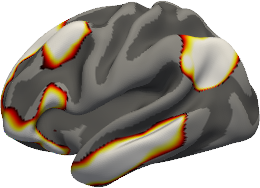

In [16]:
# Single overlay
plotter_lh.overlay(
    np.where(grad_lh > 4.0, grad_lh, np.nan),
    cmap=nilearn_cmaps["black_red"],
    vmin=4.0,
    vmax=6.0,
)

plotter_lh.screenshot()

We can also layer multiple overlays on top of each other. Each is blended together just like in matplotlib.

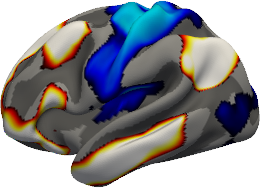

In [17]:
# Add another overlay
plotter_lh.overlay(
    np.where(grad_lh < -4.0, grad_lh, np.nan),
    cmap=nilearn_cmaps["black_blue_r"],
    vmin=-6.0,
    vmax=-4.0,
)

plotter_lh.screenshot()

## Montages

We can put these simple screenshots together into more complex multi-panel figures using `yaspy.montage()`.

First, let's make a fairly typical montage of lateral and medial views for left and right hemispheres. First set up two plotters and create the two overlays.

In [18]:
# Both hemi typical montage
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)
plotter_rh = yaspy.Plotter(surf_rh_path, hemi="rh", sulc=sulc_rh_path)

plotter_lh.overlay(
    np.where(grad_lh > 4.0, grad_lh, np.nan),
    cmap=nilearn_cmaps["black_red"],
    vmin=4.0,
    vmax=6.0,
)

plotter_rh.overlay(
    np.where(grad_rh > 4.0, grad_rh, np.nan),
    cmap=nilearn_cmaps["black_red"],
    vmin=4.0,
    vmax=6.0,
);

Now we take the four screenshots, arrange them in a grid of `images` (i.e. just a list of lists), and then combine with `yaspy.montage()`.

The `montage()` function handles alignment of images within rows/columns and padding/resizing. The idea is to automate the stuff we often do in powerpoint to align/distribute images in a grid.

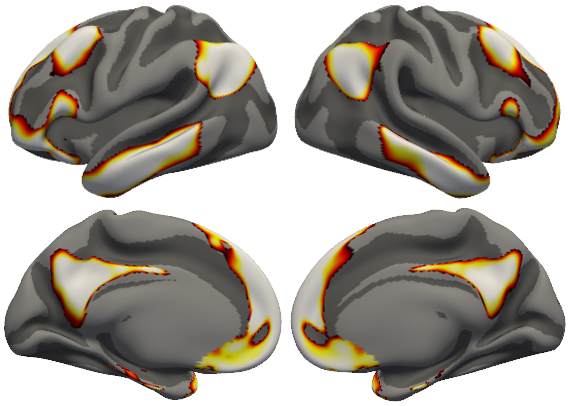

In [19]:
images = [
    [plotter_lh.screenshot("lateral"), plotter_rh.screenshot("lateral")],
    [plotter_lh.screenshot("medial"), plotter_rh.screenshot("medial")],
]

# Nb, shareh=True makes all rows same height.
yaspy.montage(images, pad=4, shareh=True)

Montages can have empty cells, coded as `None`, which just get filled in as background.

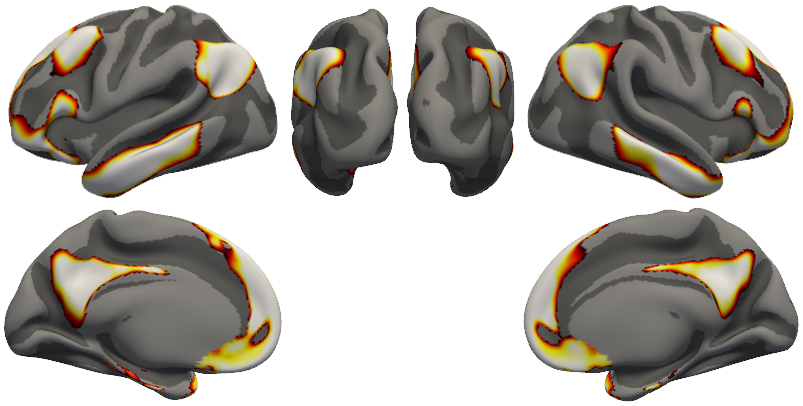

In [20]:
images = [
    [
        plotter_lh.screenshot("lateral"),
        plotter_lh.screenshot("posterior"),
        plotter_rh.screenshot("posterior"),
        plotter_rh.screenshot("lateral"),
    ],
    [
        plotter_lh.screenshot("medial"),
        None,
        None,
        plotter_rh.screenshot("medial"),
    ],
]

yaspy.montage(images, pad=4, shareh=True)

Since `montage` just returns a PIL Image, you can make montages out of other montages.

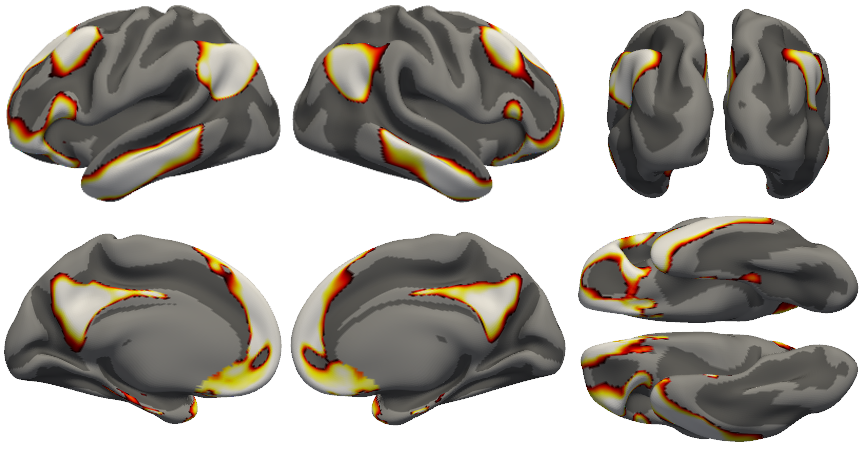

In [21]:
# Big complicated montage
images = [
    [
        plotter_lh.screenshot("lateral"),
        plotter_rh.screenshot("lateral"),
        yaspy.montage(
            [
                plotter_lh.screenshot("posterior"),
                plotter_rh.screenshot("posterior"),
            ],
            pad=4,
        ),
    ],
    [
        plotter_lh.screenshot("medial"),
        plotter_rh.screenshot("medial"),
        yaspy.montage(
            [
                [plotter_lh.screenshot("inferior")],
                # Nb, custom camera position for this view.
                [plotter_rh.screenshot(((0, 0, -500), (0, 0, 0), (-1, 0, 0)))],
            ],
            pad=4,
        ),
    ],
]

yaspy.montage(images, pad=4)

## Matplotlib integration

Yaspy is designed to be used within matplotlib. First, you can just plot a yaspy screenshot using `pyplot.imshow()`.

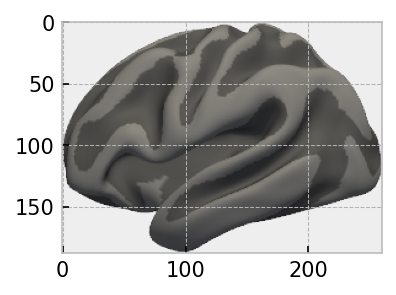

In [22]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)

plt.figure(figsize=(3, 2))
plt.imshow(plotter_lh.screenshot())

As a convenience, there is also a `Plotter.imshow()` method.

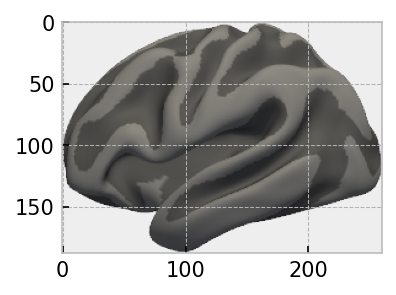

In [23]:
plt.figure(figsize=(3, 2))
plotter_lh.imshow()

As a more complete example, here we make a three panel figure of the RSFC principal gradient in matplotlib, including an inset colorbar.

Importantly, the `Overlay` objects are instances of matplotlib [`ScalarMappable`](https://matplotlib.org/stable/api/cm_api.html#matplotlib.cm.ScalarMappable), so they can be used to make colorbars. See for example [this tutorial](https://matplotlib.org/stable/users/explain/colors/colorbar_only.html).

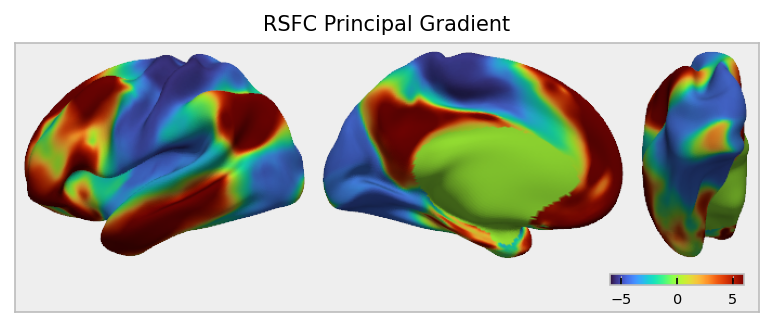

In [24]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)

# Make the overlay. Save a reference to the overlay object (i.e. ScalarMappable), to use
# for the colorbar.
overlay = plotter_lh.overlay(
    grad_lh,
    cmap="turbo",
    vmin=-6.0,
    vmax=6.0,
)

# Create the montage
img = yaspy.montage(
    [
        plotter_lh.screenshot("lateral"),
        plotter_lh.screenshot("medial"),
        plotter_lh.screenshot(((0, -500, -200), (0, 0, 0), (0, 0, 1))),
    ],
    pad=8,
)

# Make the figure
W, H = img.size
f, ax = plt.subplots()

plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Create some room in the axes for the colorbar
ymax, ymin = plt.ylim()
plt.ylim(ymax + 0.2 * H, ymin)

# Inset colorbar
cax = ax.inset_axes((0.8, 0.1, 0.18, 0.04))
cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize="x-small")

plt.title("RSFC Principal Gradient", fontsize="medium")
plt.savefig("rsfc_principal_gradient.png", dpi=200, bbox_inches="tight")

## Parcellation boundaries

We can also show parcellation boundaries with yaspy. To see how, we'll first download the [Schaefer 400 parcellation](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

In [25]:
from urllib.request import urlretrieve

In [26]:
filename = "Schaefer2018_400Parcels_7Networks_order.dlabel.nii"

urlretrieve(
    f"https://github.com/ThomasYeoLab/CBIG/raw/refs/heads/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/{filename}",
    filename,
)

('Schaefer2018_400Parcels_7Networks_order.dlabel.nii',
 <http.client.HTTPMessage at 0x29a732e70>)

Load the parcellation (it's in cifti dlabel format), getting the parcellation label arrays for left and right hemisphere, as well as the official color lookup table.

In [27]:
# Load parcellation label arrays
parc = nib.load(filename)
parc_data = parc.get_fdata().squeeze().astype(np.int32)
parc_data_lh, parc_data_rh = np.split(parc_data, 2)
print(parc_data_lh.shape, parc_data_rh.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(32492,) (32492,)


In [28]:
# Load the color lookup table
lut = parc.header.get_axis(0).label[0]

for ii, (k, v) in enumerate(lut.items()):
    print(f"{k}: {v}")
    if ii >= 5:
        break

lut = np.array([v[1] for v in lut.values()])
print("Color LUT shape:", lut.shape)

0: ('???', (1.0, 1.0, 1.0, 0.0))
1: ('7Networks_LH_Vis_1', (0.470588, 0.0666667, 0.501961, 1.0))
2: ('7Networks_LH_Vis_2', (0.470588, 0.0666667, 0.505882, 1.0))
3: ('7Networks_LH_Vis_3', (0.470588, 0.0666667, 0.509804, 1.0))
4: ('7Networks_LH_Vis_4', (0.470588, 0.0666667, 0.513726, 1.0))
5: ('7Networks_LH_Vis_5', (0.470588, 0.0666667, 0.517647, 1.0))
Color LUT shape: (401, 4)


Apply the color lookup table to get the correct RGB value for each vertex, based on its ROI membership.

In [29]:
# Get the RGBA colors per ROI
parc_rgba_lh = lut[parc_data_lh]
parc_rgba_rg = lut[parc_data_rh]

Ok, now we can make a screenshot of the parcellation with the official color scheme.

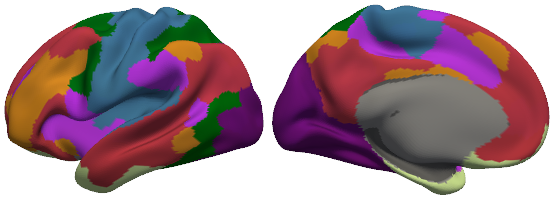

In [30]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)

plotter_lh.overlay(parc_rgba_lh)

yaspy.montage(
    [plotter_lh.screenshot("lateral"), plotter_lh.screenshot("medial")], pad=4
)

Finally, let's add the border of each ROI, in semi-transparent black.

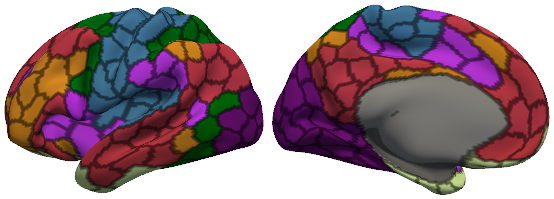

In [31]:
plotter_lh.border(parc_data_lh, alpha=0.5)

yaspy.montage(
    [plotter_lh.screenshot("lateral"), plotter_lh.screenshot("medial")], pad=4
)